# Thêm thư viện cần thiết


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
import pandas as pd
import warnings
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from sklearn.preprocessing import StandardScaler
from sklearn.utils import column_or_1d
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')


# Nạp dữ liệu


In [17]:
train_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/8_2/eth/ethereum_train_8_2.csv", parse_dates=True, index_col=0)
train_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2020-06-01,0.23180,0.24981,0.23085,0.24797,11970598,USD
2020-06-02,0.24801,0.25321,0.22795,0.23794,12686011,USD
2020-06-03,0.23790,0.24476,0.23384,0.24452,8151002,USD
2020-06-04,0.24453,0.24641,0.23668,0.24337,8749785,USD
2020-06-05,0.24337,0.24750,0.23970,0.24023,7754761,USD


In [18]:
train = train_ETH[["Open"]]
train.head(5)

,Open
Date,
2020-06-01,0.23180
2020-06-02,0.24801
2020-06-03,0.23790
2020-06-04,0.24453
2020-06-05,0.24337


In [19]:
test_ETH = pd.read_csv("/content/drive/My Drive/Năm 3/Làm nhóm HK2 2021 - 2022/Cá nhân/More/SF/Dataset/Data/8_2/eth/ethereum_test_8_2.csv", parse_dates=True, index_col=0)
test_ETH.head(5)

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2022-01-07,3.40722,3.41326,3.07730,3.19531,979252,USD
2022-01-08,3.19814,3.24446,3.00176,3.08002,566062,USD
2022-01-09,3.07989,3.21034,3.06047,3.15030,415868,USD
2022-01-10,3.15027,3.17996,2.93168,3.08543,804376,USD
2022-01-11,3.08464,3.26278,3.05340,3.23789,505208,USD


In [20]:
test = test_ETH[["Open"]]
test.head(5)

,Open
Date,
2022-01-07,3.40722
2022-01-08,3.19814
2022-01-09,3.07989
2022-01-10,3.15027
2022-01-11,3.08464


In [21]:
df = pd.concat([train.reset_index(level=0), test.reset_index(level=0)],    # Combine vertically
                          ignore_index = True,
                          sort = False)
df.index=df.Date
df.drop("Date", axis=1, inplace=True)
df.head(5)    

,Open
Date,
2020-06-01,0.23180
2020-06-02,0.24801
2020-06-03,0.23790
2020-06-04,0.24453
2020-06-05,0.24337


# Vẽ đồ thị

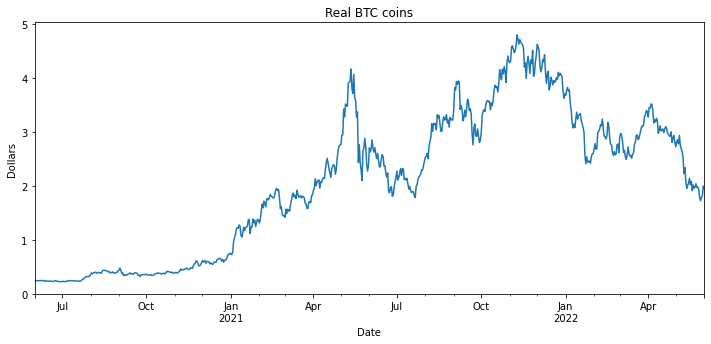

In [22]:
# Thư viện vẽ đồ thị
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real BTC coins'
ylabel='Dollars'
xlabel='Date' 

ax = df['Open'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

# Kiểm tra tính dừng của chuỗi

In [23]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")


In [24]:
adf_test(df['Open'], 'Bitcoin Price')


Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic         -1.628066
p-value                     0.468503
Number of lags used         6.000000
Number of observations    724.000000
critical value (1%)        -3.439414
critical value (5%)        -2.865540
critical value (10%)       -2.568900
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


##### Nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng


# Lấy sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng


In [25]:
df['diff1'] = df['Open'].diff()
df.head()


,Open,diff1
Date,,
2020-06-01,0.23180,NaN
2020-06-02,0.24801,0.01621
2020-06-03,0.23790,-0.01011
2020-06-04,0.24453,0.00663
2020-06-05,0.24337,-0.00116


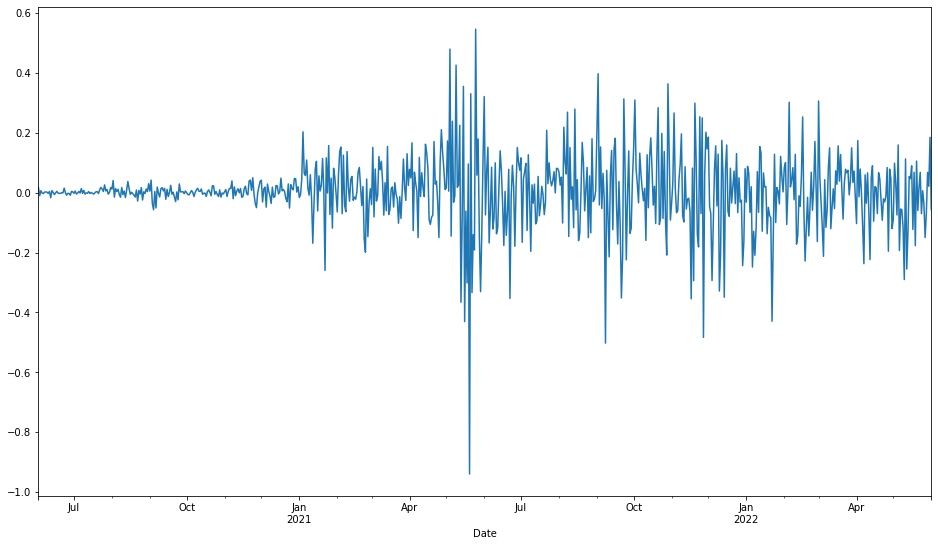

In [26]:
df['diff1'].dropna().plot(figsize=(16, 9))


# Kiểm định tính dừng của chuỗi tại sai phân bậc 1


In [27]:
adf_test(df['diff1'], 'Bitcoin Price at First Difference')


Augmented Dickey-Fuller Test: Bitcoin Price at First Difference
ADF test statistic       -1.017531e+01
p-value                   6.917300e-18
Number of lags used       5.000000e+00
Number of observations    7.240000e+02
critical value (1%)      -3.439414e+00
critical value (5%)      -2.865540e+00
critical value (10%)     -2.568900e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


##### Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1


# Thực hiện xây dựng mô hình ARIMA

## Cần chuẩn hóa dữ liệu để thuận tiện cho việc xây dựng mô hình

In [28]:
df_scaled = df.copy().drop(columns=['diff1'])

scaler = StandardScaler()

df_scaled['Open'] = scaler.fit_transform(df_scaled['Open'].values.reshape(-1, 1))
df_scaled.head()

,Open
Date,
2020-06-01,-1.394670
2020-06-02,-1.382460
2020-06-03,-1.390075
2020-06-04,-1.385081
2020-06-05,-1.385955


## Chia dữ liệu thành tập train và tập test

In [29]:
interrupt = len(train)
interrupt

585

In [30]:
index_test = df_scaled.index[interrupt:]
print(train.shape)
print(test.shape)
print(index_test.shape)

(585, 1)
(146, 1)
(146,)


In [31]:
train.tail()

,Open
Date,
2022-01-02,3.76567
2022-01-03,3.83070
2022-01-04,3.76462
2022-01-05,3.78447
2022-01-06,3.53615


In [32]:
test.head()

,Open
Date,
2022-01-07,3.40722
2022-01-08,3.19814
2022-01-09,3.07989
2022-01-10,3.15027
2022-01-11,3.08464


## Tìm các hệ số p, q và d phù hợp cho mô hình ARIMA

In [33]:
warnings.filterwarnings('ignore')


def arima_model(ts_data):
    fit_model = auto_arima(ts_data, test='adf', seasonal=False, trace=True)
    print(fit_model.summary())
    return fit_model


#### Dựa vào chỉ số AIC
- Chỉ số AIC càng thấp thì mô hình càng phù hợp

In [34]:
fitted = arima_model(train)
fitted.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-816.824, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-812.343, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-819.812, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-819.565, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-813.052, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-817.836, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-817.848, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-815.831, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-820.123, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-818.176, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-818.205, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-819.833, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-816.170, Time=0.30 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.957 seconds
                      

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  585
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 412.061
Date:                Sun, 26 Jun 2022   AIC                           -820.123
Time:                        02:27:54   BIC                           -811.383
Sample:                             0   HQIC                          -816.717
                                - 585                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1247      0.031     -4.015      0.000      -0.186      -0.064
sigma2         0.0143      0.000     38.377      0.000       0.014       0.015
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2018.72
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              77.14   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test


In [35]:
pred = fitted.predict(len(test))
pred


array([3.56711587, 3.56325438, 3.56373592, 3.56367587, 3.56368336,
       3.56368242, 3.56368254, 3.56368252, 3.56368253, 3.56368253,
       3.56368253, 3.56368253, 3.56368253, 3.56368253, 3.56368253,
       3.56368253, 3.56368253, 3.56368253, 3.56368253, 3.56368253,
       3.56368253, 3.56368253, 3.56368253, 3.56368253, 3.56368253,
       3.56368253, 3.56368253, 3.56368253, 3.56368253, 3.56368253,
       3.56368253, 3.56368253, 3.56368253, 3.56368253, 3.56368253,
       3.56368253, 3.56368253, 3.56368253, 3.56368253, 3.56368253,
       3.56368253, 3.56368253, 3.56368253, 3.56368253, 3.56368253,
       3.56368253, 3.56368253, 3.56368253, 3.56368253, 3.56368253,
       3.56368253, 3.56368253, 3.56368253, 3.56368253, 3.56368253,
       3.56368253, 3.56368253, 3.56368253, 3.56368253, 3.56368253,
       3.56368253, 3.56368253, 3.56368253, 3.56368253, 3.56368253,
       3.56368253, 3.56368253, 3.56368253, 3.56368253, 3.56368253,
       3.56368253, 3.56368253, 3.56368253, 3.56368253, 3.56368

# Vẽ đồ thị cho tập test và kết quả dự đoán

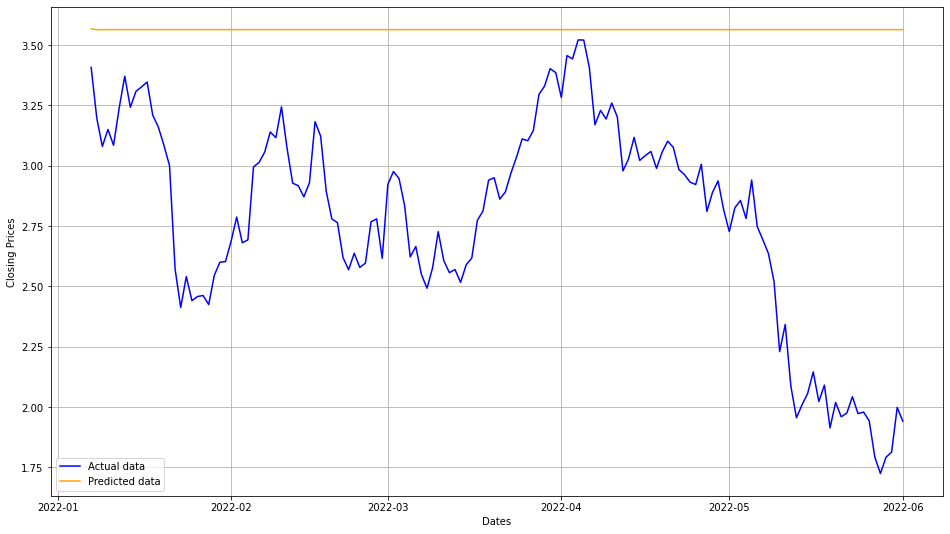

In [36]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test, 'blue', label='Actual data')
plt.plot(pred_series, 'orange', label='Predicted data')
plt.legend()


# Đưa dữ liệu về miền giá trị ban đầu


In [37]:
actual = column_or_1d(test)
pred = column_or_1d(pred)

inv_actual = scaler.inverse_transform(actual.reshape(-1, 1))
inv_pred = scaler.inverse_transform(pred.reshape(-1, 1))


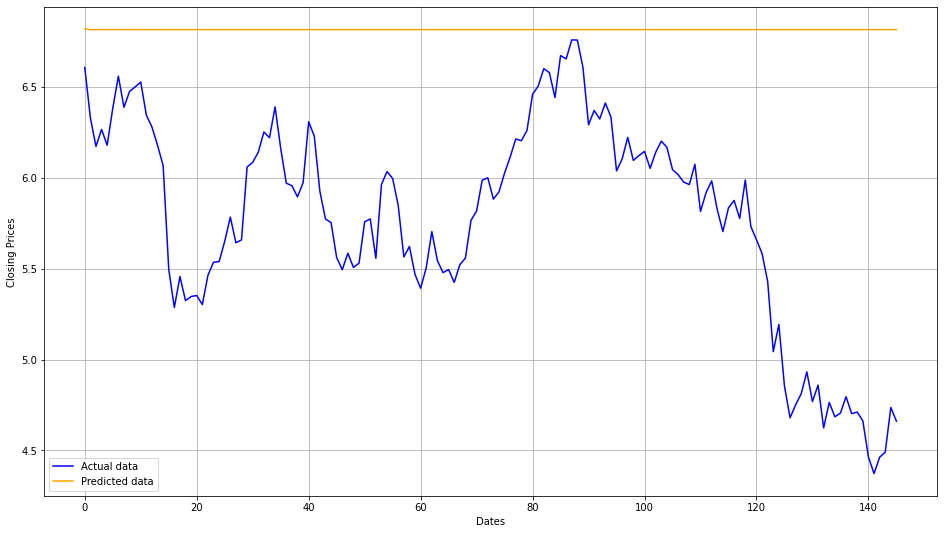

In [38]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_actual, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()


# Đánh giá mô hình qua các chỉ số MAE, MAPE, MSE, RMSE

In [39]:
# mae = mean_absolute_error(inv_actual, inv_pred)
mape = mean_absolute_percentage_error(inv_actual, inv_pred)
mse = mean_squared_error(inv_actual, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_actual, inv_pred)

# print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
# print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")


MAPE: 19.25%
RMSE: 1.19
R2: -3.32
